In [39]:
! pwd

/root/host_home/luca/healthy


In [1]:
import anndata
import scanpy as sc
from pandas import read_csv

In [6]:
# adata = sc.read_10x_mtx(
#     '/root/datos/sensence/emilio/prepros/input/SRR14646407Solo.out/Gene/raw',  # replace with your directory path
#     var_names='gene_symbols',  # use 'gene_ids' if you want to use the unique gene IDs instead
#     cache=True
# )

In [2]:
filters = read_csv('../samplesheet_scrnaseq_preprocessing.csv')

dataset_str = 'Emilio'

id_row = filters[filters.id == dataset_str]
file_str = 'emilio.h5ad'

In [3]:
# adata.write_h5ad(f'/root/datos/maestria/netopaas/luca/data/12_input_adatas/{file_str}')
adata = anndata.read_h5ad(f'/root/datos/maestria/netopaas/luca/data/12_input_adatas/{file_str}')

## 3.1.1 Automated annotation

For a more detailed walkthrough of the process go to `../HCA-Lung/AutoLung.ipynb` or even https://docs.scarches.org/en/latest/hlca_map_classify.html

IT IS IMPORTANT THAT THE QUERY DATA IS IN RAW COUNTS, WE CHECK THAT HERE:


In [7]:
adata.X.nnz

15987914

In [8]:
num_zeros = adata.X.shape[0] * adata.X.shape[1] - adata.X.nnz
total_elements = adata.X.shape[0] * adata.X.shape[1]
percentage_zeros = (num_zeros / total_elements) * 100
percentage_zeros

99.94854425123447

In [9]:
adata.X[:2100, :2200].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
import pandas as pd
import anndata as ad
import numpy as np

import scarches as sca
import gdown
import gzip
import shutil
from scipy import sparse

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../single-cell-tutorial/download_scripts'))
from functions import remove_repeated_var_inds, join_map_mart

/usr/local/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


### Load Query dataset

In [7]:
batch_key = 'dataset'
name = dataset_str.split('_')[0]
query_batch = [f'lung_{name}']
cell_type_key = 'scanvi_label'
data_dir = '/root/datos/maestria/netopaas/lung_scRNA'
backup_dir = '/root/datos/maestria/netopaas/luca_explore'
ref_model_path = f'{data_dir}/HCA_Lung/HLCA_reference_model'

#Important to check how many epochs would be ideal
surgery_epochs = 200
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [8]:
adata_ref = sc.read_h5ad(f'{data_dir}/HCA_Lung/HLCA_emb_and_metadata.h5ad')

In [13]:
adata_query_unprep = adata.copy()

# We need RAW count data for the model we are using so we get it from adata.layers
#adata_query_unprep.X = adata_query_unprep.layers['counts']

For faster computation convert the matrix to sparse.
First check with `adata.X` if it is sparse

In [14]:
adata.X
# adata_query_unprep.X = sparse.csr_matrix(adata_query_unprep.X)

<737280x42143 sparse matrix of type '<class 'numpy.float32'>'
	with 15987914 stored elements in Compressed Sparse Row format>

### Change to Ensembl IDs

Revert to ensemble ids using the assembly reference gch38 (or hg19 in the comments) used in the experiment.
Doing this via THE PACKAGE Biomart always leaves us with some gaps because there are many manually annotated genes.

If your query feature naming does not match your reference model feature naming, you will need to add the right feature names. For the HLCA reference, the mapping of the 2000 input gene IDs to their gene names is stored on the HLCA Zenodo page, so you can add gene ids using that mapping. Alternatively, you can map your gene IDs to gene names (or the reverse) using BioMart mapping tables. In most cases your raw data includes both gene IDs and names, in which case mapping is not necessary.

Let’s download the HLCA-specific gene mapping:

In [15]:
path_gene_mapping_df = f'{data_dir}/HCA_Lung/HLCA_reference_model_gene_order_ids_and_symbols.csv'

In [16]:
# Download gene information from HLCA github:
# url = "https://zenodo.org/record/7599104/files/HLCA_reference_model_gene_order_ids_and_symbols.csv"
# gdown.download(url, path_gene_mapping_df, quiet=False)

In [17]:
gene_id_to_gene_name_df = pd.read_csv(path_gene_mapping_df, index_col=0)

# Store your gene names in an adata.var.column if they are currently the index:
# if gene names are in .var.index:
adata_query_unprep.var["gene_names"] = adata_query_unprep.var.index
gene_name_column_name = "gene_names"

Map gene names to gene ids for all of the 2000 reference model genes that we can find in our data:

Check number of detected genes:

In [18]:
n_overlap = (
    adata_query_unprep.var[gene_name_column_name]
    .isin(gene_id_to_gene_name_df.gene_symbol)
    .sum()
)
n_genes_model = gene_id_to_gene_name_df.shape[0]
print(
    f"Number of model input genes detected: {n_overlap} out of {n_genes_model} ({round(n_overlap/n_genes_model*100)}%)"
)



Number of model input genes detected: 1765 out of 2000 (88%)


Subset query data to only the genes that are part of the modeling input, then map gene names to gene ids using the table above. Store the resulting ids both in the .var.index (for scArches) and in a .var[gene_ids] (for merging duplicate genes).

In [19]:
adata_query_unprep = adata_query_unprep[
    :,
    adata_query_unprep.var[gene_name_column_name].isin(
        gene_id_to_gene_name_df.gene_symbol
    ),
].copy()  # subset your data to genes used in the reference model
adata_query_unprep.var.index = adata_query_unprep.var[gene_name_column_name].map(
    dict(zip(gene_id_to_gene_name_df.gene_symbol, gene_id_to_gene_name_df.index))
)  # add gene ids for the gene names, and store in .var.index
# remove index name to prevent bugs later on
adata_query_unprep.var.index.name = None
adata_query_unprep.var["gene_ids"] = adata_query_unprep.var.index


In [20]:
adata_query_unprep.var.head(3)

,gene_ids,feature_types,gene_names
ENSG00000188290,ENSG00000188290,Gene Expression,HES4
ENSG00000187608,ENSG00000187608,Gene Expression,ISG15
ENSG00000162571,ENSG00000162571,Gene Expression,TTLL10


In [21]:
def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    adata.obs[col] = adata.obs[col].astype('category')
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    cat = adata.obs[col].values
    indicator = sparse.coo_matrix(
        (np.broadcast_to(True, adata.n_obs), (cat.codes, np.arange(adata.n_obs))),
        shape=(len(cat.categories), adata.n_obs),
    )

    return ad.AnnData(
        indicator @ adata.X, var=adata.var, obs=pd.DataFrame(index=cat.categories)
    )

shape before merging:

Now merge. Note that all var columns will be dropped after merging (as we don’t specify how to merge). As the merging is done based on .obs indices in the function above, we transpose our anndata object and re-transpose it after merging.

In [22]:
adata_query_unprep = sum_by(adata_query_unprep.transpose(), col="gene_ids").transpose()

In [29]:
adata_query_unprep.shape

(737280, 1765)

add back gene ids:

In [24]:
adata_query_unprep.var = adata_query_unprep.var.join(gene_id_to_gene_name_df).rename(columns={"gene_symbol":"gene_names"})

### Surgery

We pad missing query genes with zeros and reorder the available ones to ensure data corectness and smooth running of the scArches reference mapping.

In [41]:
adata_query = sca.models.SCANVI.prepare_query_anndata(
    adata = adata_query_unprep,
    # return_reference_var_names=True,
    reference_model = ref_model_path,
    inplace=False)

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   
INFO     Found 88.25% reference vars in query data.                                                                


This line should be kept unchanged due to the structure of the pre-trained reference model.

In [42]:
adata_query.obs['scanvi_label'] = 'unlabeled'

Now we perform scArches “surgery”.

Note: if you use gene names rather than ensembl IDs in your query_data.var.index, you will get a warning that your genes (var_names) do not match the training genes. You can ignore this warning, as long as you have done the gene check in the beginning of the notebook.

In [43]:
from scvi.model.base._utils import _load_saved_files
attr_dict, var_names, model_state_dict, adata_ = _load_saved_files(ref_model_path, load_adata=False, map_location='cpu')

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   


Thanks to exploring the model we can deduce what .obs we need and the name we assigned. In this case we need to define a 'dataset'
column in obs to define the batches. Seeing as to how every sample ia new day in the experiment we define the batches as the samples.

We can load the model with this command or train it if we havent got it

In [49]:
adata_query

AnnData object with n_obs × n_vars = 737280 × 2000
    obs: 'scanvi_label', 'sample'
    var: 'gene_names'

In [44]:
adata_query.obs['sample'] = 'emilio'

In [50]:
adata_query.obs['dataset'] = adata_query.obs['sample']
# adata_query.obs['sample'] = adata_query.obs['sample'].astype('string')
# adata_query.obs['dataset'] = adata_query.obs['dataset'].astype('string')

In [51]:
for col in adata_query.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_query.obs[col]):
        adata_query.obs[col] = adata_query.obs[col].astype('str')


In [10]:
# Convert all mito falgs into false because we are using the latent genes of the HCA_lung model
adata_query = sc.read_h5ad(f'{backup_dir}/surgeries/query_{name}.h5ad')
adata_query.var.mito = False
# adata_query.write_h5ad(f'{backup_dir}/surgeries/query_{name}.h5ad')

Apparently we have to aks for cuda availability explicitly for scArches to recognize that we have GPU

In [4]:
import torch
torch.cuda.is_available()

True

In [53]:
surgery_model = sca.models.SCANVI.load_query_data(
        adata_query,
        ref_model_path,
        freeze_dropout = True,
    )

INFO     File /root/datos/maestria/netopaas/lung_scRNA/HCA_Lung/HLCA_reference_model/model.pt already downloaded   


/usr/local/lib/python3.11/site-packages/scvi/model/_scanvi.py:140: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


In [ ]:
%%time
surgery_model.train(
     max_epochs=surgery_epochs,
    **early_stopping_kwargs_surgery
)

INFO     Training for 200 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 29/200:  14%|█████████████▋                                                                                    | 28/200 [1:03:12<6:12:38, 129.99s/it, v_num=1, train_loss_step=-34.5, train_loss_epoch=-29.1]

In [11]:
# surgery_model.save(f'{backup_dir}/surgeries/{name}', overwrite=True)
surgery_model = sca.models.SCANVI.load(f'{backup_dir}/surgeries/{name}/', adata_query)

INFO     File /root/datos/maestria/netopaas/luca_explore/surgeries/Emilio/model.pt already downloaded              


/usr/local/lib/python3.11/site-packages/scvi/model/_scanvi.py:140: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


### Get latent representation
Here we will calculate the “latent representation”, or “low-dimensional embedding” of your dataset. This embedding is in the same space as the HLCA core/reference embedding that you loaded in the beginning of the script. Hence, we can combine the two embeddings afterwards (HLCA + your new data), and do joint clustering, UMAP embedding, label transfer etc.!

In [12]:
adata_query_latent = sc.AnnData(surgery_model.get_latent_representation(adata_query))
adata_query_latent.obs = adata_query.obs.loc[adata_query.obs.index,:]

In [13]:
adata_query_latent.write_h5ad(f'{backup_dir}/surgeries/latent_{name}.h5ad')
# adata_query_latent = sc.read_h5ad(f'{backup_dir}/surgeries/latent_{name}.h5ad')

### Combine embeddings
We add “reference or query” metadata to acquire more information and better analyse the integration level.

In [14]:
adata_query_latent.obs['ref_or_query'] = "query"
adata_ref.obs['ref_or_query'] = "ref"

We will now combine the two embeddings to enable joing clustering etc. If you expect non-unique barcodes (.obs index), set index_unique to e.g. “_” and batch_key to the obs column that you want to use as barcode suffix (e.g. “dataset”).

In [15]:
combined_emb = adata_ref.concatenate(adata_query_latent, index_unique=None) # index_unique="_", batch_key="dataset") # alternative

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [16]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')
# combined_emb = sc.read_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

Note that if wanted, this embedding can be added to the full, joint HLCA + query data object (including gene counts). The full HLCA, including normalized counts is publicly available. For now, we will just work with the embedding, since that is all we need to perform joint plotting and label transfer.

### Label transfer
Next, we use a knn classifier to transfer the lables from the reference to the query. We do this for every level of the annotation (i.e. level 1-5). Note that some cell types don’t have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. For those cell types, we “propagate” to the higher levels, i.e. you will see “3_Mast cells” in level 4 and 5 annotations. (Most cell types don’t have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5.

In [17]:
celltypes = f'{data_dir}/HCA_Lung/HLCA_celltypes_ordered.csv'

In [18]:
# url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv'
# gdown.download(url, celltypes, quiet=False)

In [19]:
cts_ordered = read_csv(celltypes,index_col=0)

In [20]:
#Now run the label transfer commands. Note that this might take quite a while if you have a large query dataset! For our small test dataset, it should not take long.

knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=adata_ref,
    train_adata_emb="X",
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

In [21]:
%%time

labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=adata_query_latent,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=knn_transformer,
    ref_adata_obs = adata_ref.obs.join(cts_ordered, on='ann_finest_level')
    )

finished!
CPU times: user 54min 47s, sys: 9.96 s, total: 54min 57s
Wall time: 8min 39s


With the commands above, we labeled every cell from the query. However, some cells might have high label transfer uncertainty. It is useful to set those to “unknown” instead of giving them a cell type label. This will help highlight cell types/states that are new (i.e. not present in the reference) and possible interesting, they’re worth taking a careful look at!

This uncertainty threshold limits the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022)

In [22]:
uncertainty_threshold = 0.2

In [23]:
labels.rename(columns={f'Level_{lev}':f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)},inplace=True)
uncert.rename(columns={f'Level_{lev}':f'Level_{lev}_transfer_uncert' for lev in range(1,6)},inplace=True)

combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

In [24]:
t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]

Convert uncertainties to arrays

In [25]:
combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

Convert cell type labels to categoricals, and set “nan” to NaN

In [26]:
def remove_uncert_types(combined_emb):
    import pandas as pd
    t_labels = [f'Level_{lev}_transfered_label_unfiltered' for lev in range(1,6)]
    t_uncert = [f'Level_{lev}_transfer_uncert' for lev in range(1,6)]
    
    combined_emb.obs[t_uncert] = list(np.array(combined_emb.obs[t_uncert]))

    for col, uncert in zip(t_labels,t_uncert):
        filtered_colname = col.replace('_unfiltered','')
        # too high uncertainty levels => set to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname] = combined_emb.obs[filtered_colname].astype('str')
        combined_emb.obs[filtered_colname].mask(
            combined_emb.obs[uncert] > uncertainty_threshold,
            'Unknown',
            inplace = True)

        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace('nan',np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace('nan',np.nan,inplace=True)
    return combined_emb

In [27]:
combined_emb.obs['original_ann_level_2']

GCGACCATCCCTAACC_SC22                Myeloid
P2_1_GCGCAACCAGTTAACC               Lymphoid
GCTCTGTAGTGCTGCC_SC27    Alveolar epithelium
P2_8_TTAGGACGTTCAGGCC                Myeloid
CTTGATTGTCAGTTTG_T164      Airway epithelium
                                ...         
TTTGTCATCTTTACAC                         NaN
TTTGTCATCTTTACGT                         NaN
TTTGTCATCTTTAGGG                         NaN
TTTGTCATCTTTAGTC                         NaN
TTTGTCATCTTTCCTC                         NaN
Name: original_ann_level_2, Length: 1322164, dtype: category
Categories (13, object): ['Airway epithelium', 'Alveolar epithelium', 'Blood vessels', 'Fibroblast lineage', ..., 'Myeloid', 'None', 'Smooth muscle', 'Submucosal Gland']

In [28]:
remove_uncert_types(combined_emb)

AnnData object with n_obs × n_vars = 1322164 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_

Let’s take a look at the percentage of cells set to “unknown” after our filtering:

In [29]:
print(f'Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:')
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/adata_query.n_obs*100,2)}%")



Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 0.36%
Level 2: 0.44%
Level 3: 0.46%
Level 4: 0.47%
Level 5: 0.47%


### UMAP

The UMAP plots help us perform downstream analysis, like clustering, label transfer, integration and more.

#### UMAP Query vs. Reference

In [30]:
# We save the combined embeddings (optional).
combined_emb.write_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')
# combined_emb = sc.read_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

In [32]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)

/usr/local/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [34]:
# We save the combined embeddings (optional).
# combined_emb.write_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')
import scanpy as sc
combined_emb = sc.read_h5ad(f'{backup_dir}/surgeries/combined_{name}.h5ad')

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


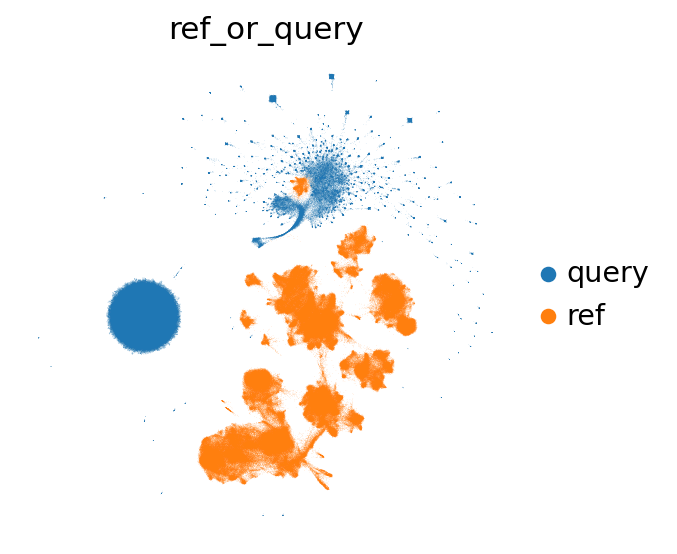

In [35]:
sc.pl.umap(
        combined_emb,
        color='ref_or_query',
        frameon=False,
        wspace=0.6
        )

#### UMAP Uncertainties

Here we show label transfer uncertainties per level. Regions with high uncertainty can highlight interesting cell types/states, not present in the reference. Note that uncertainties will get higher, the more detailed we go:

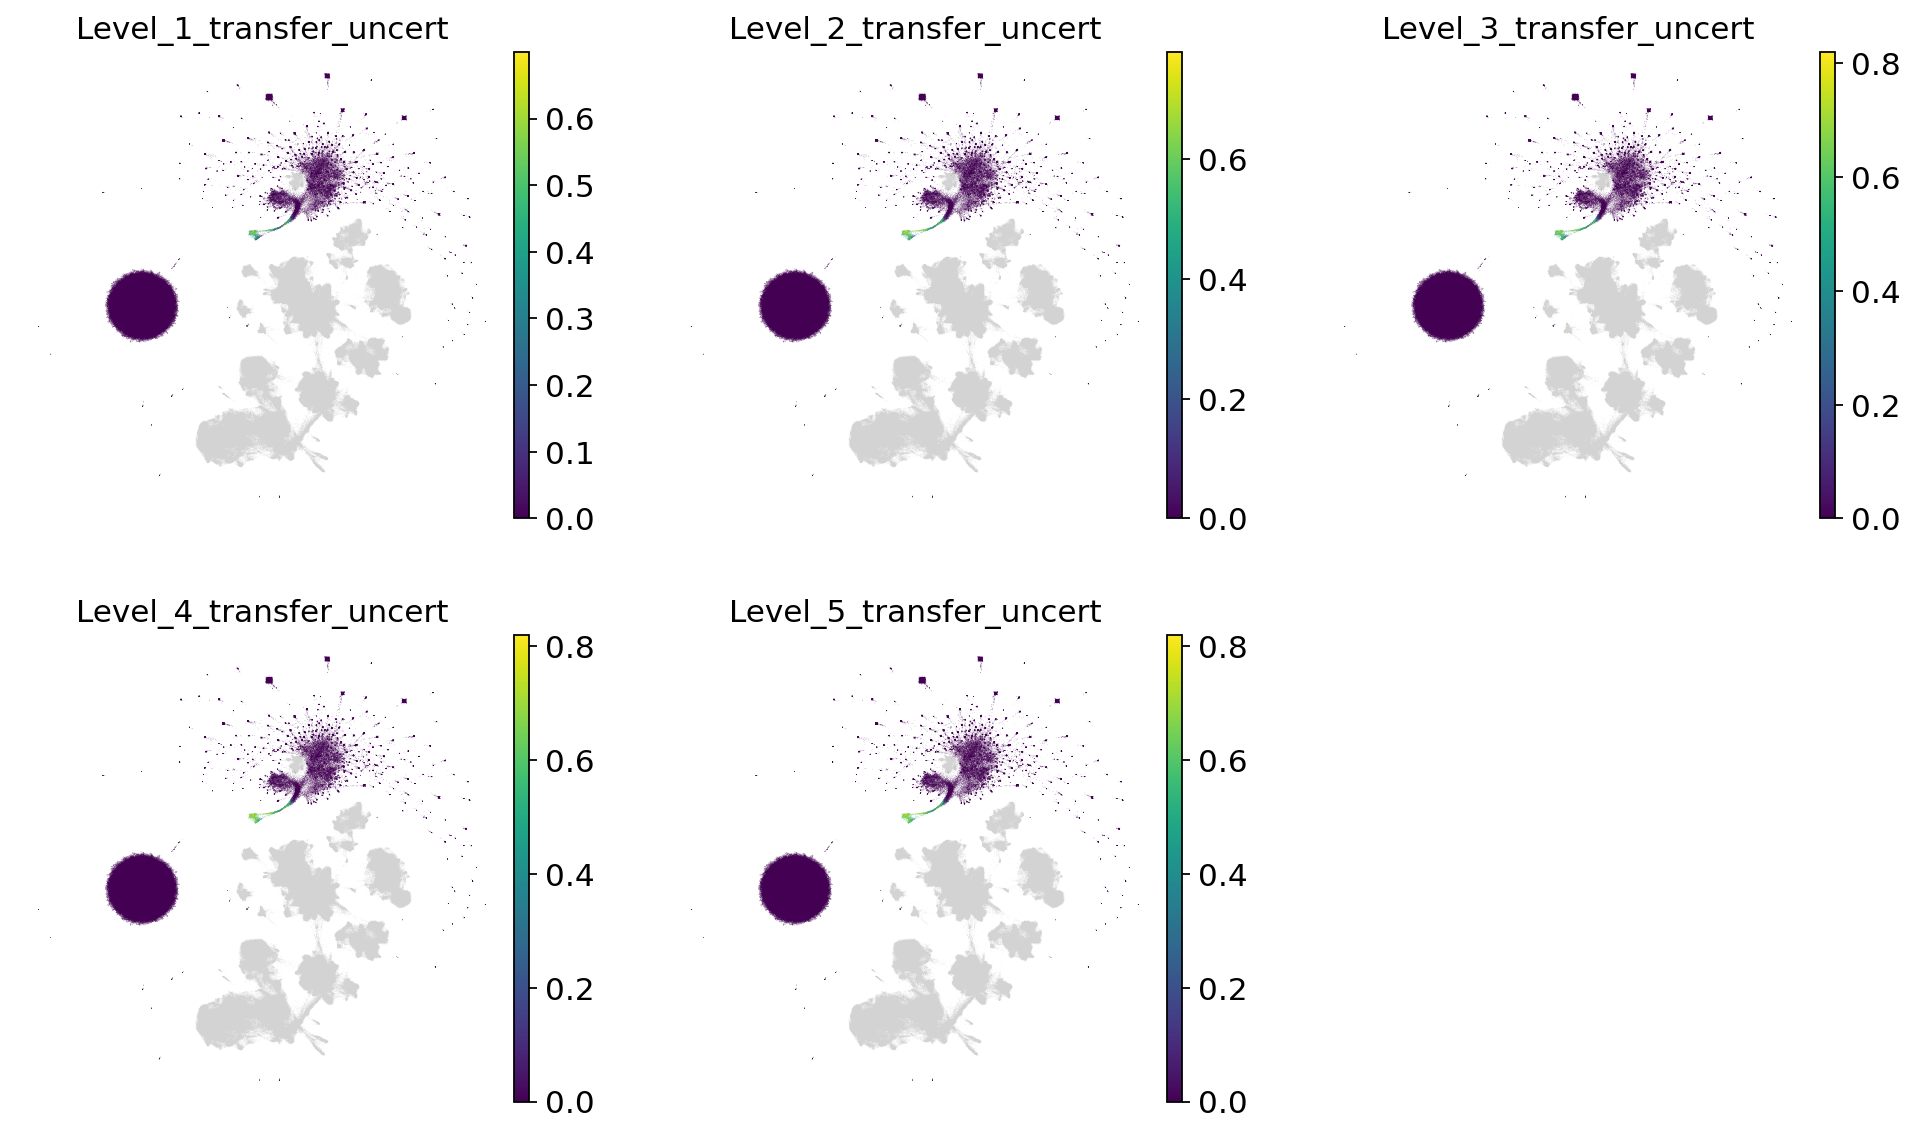

In [36]:
sc.pl.umap(
    combined_emb,
    color=[f'Level_{lev}_transfer_uncert' for lev in range(1,6)],
    ncols=3,
    frameon=False,
    )

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


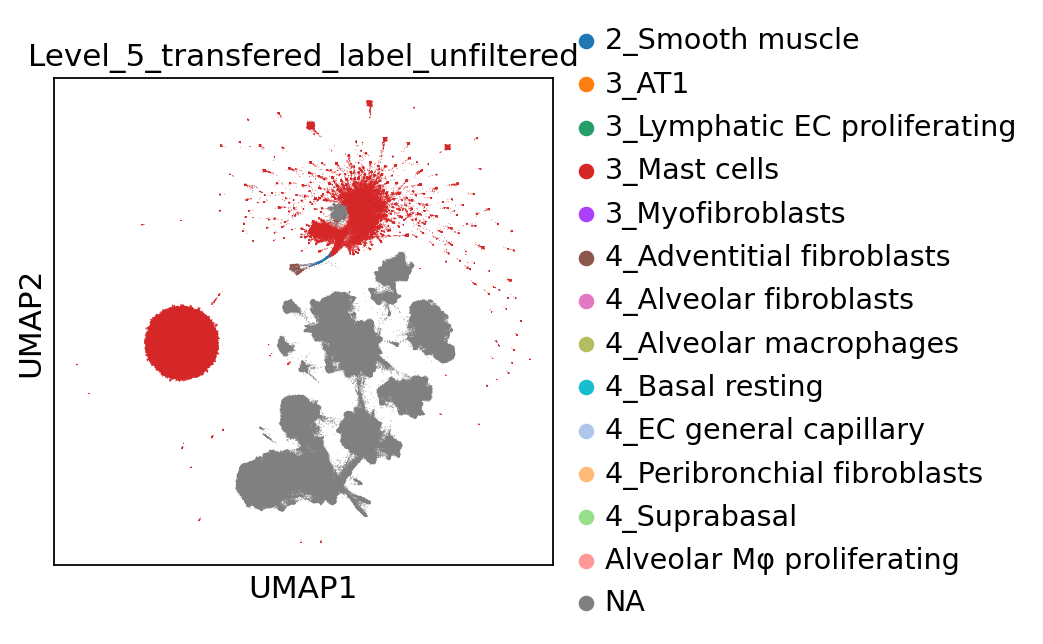

In [38]:
sc.pl.umap(
        combined_emb,
        color=[f"Level_{lev}_transfered_label_unfiltered" for lev in range(5,6)],
        na_color="grey",
        ncols=1,
        size=0.5
)

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


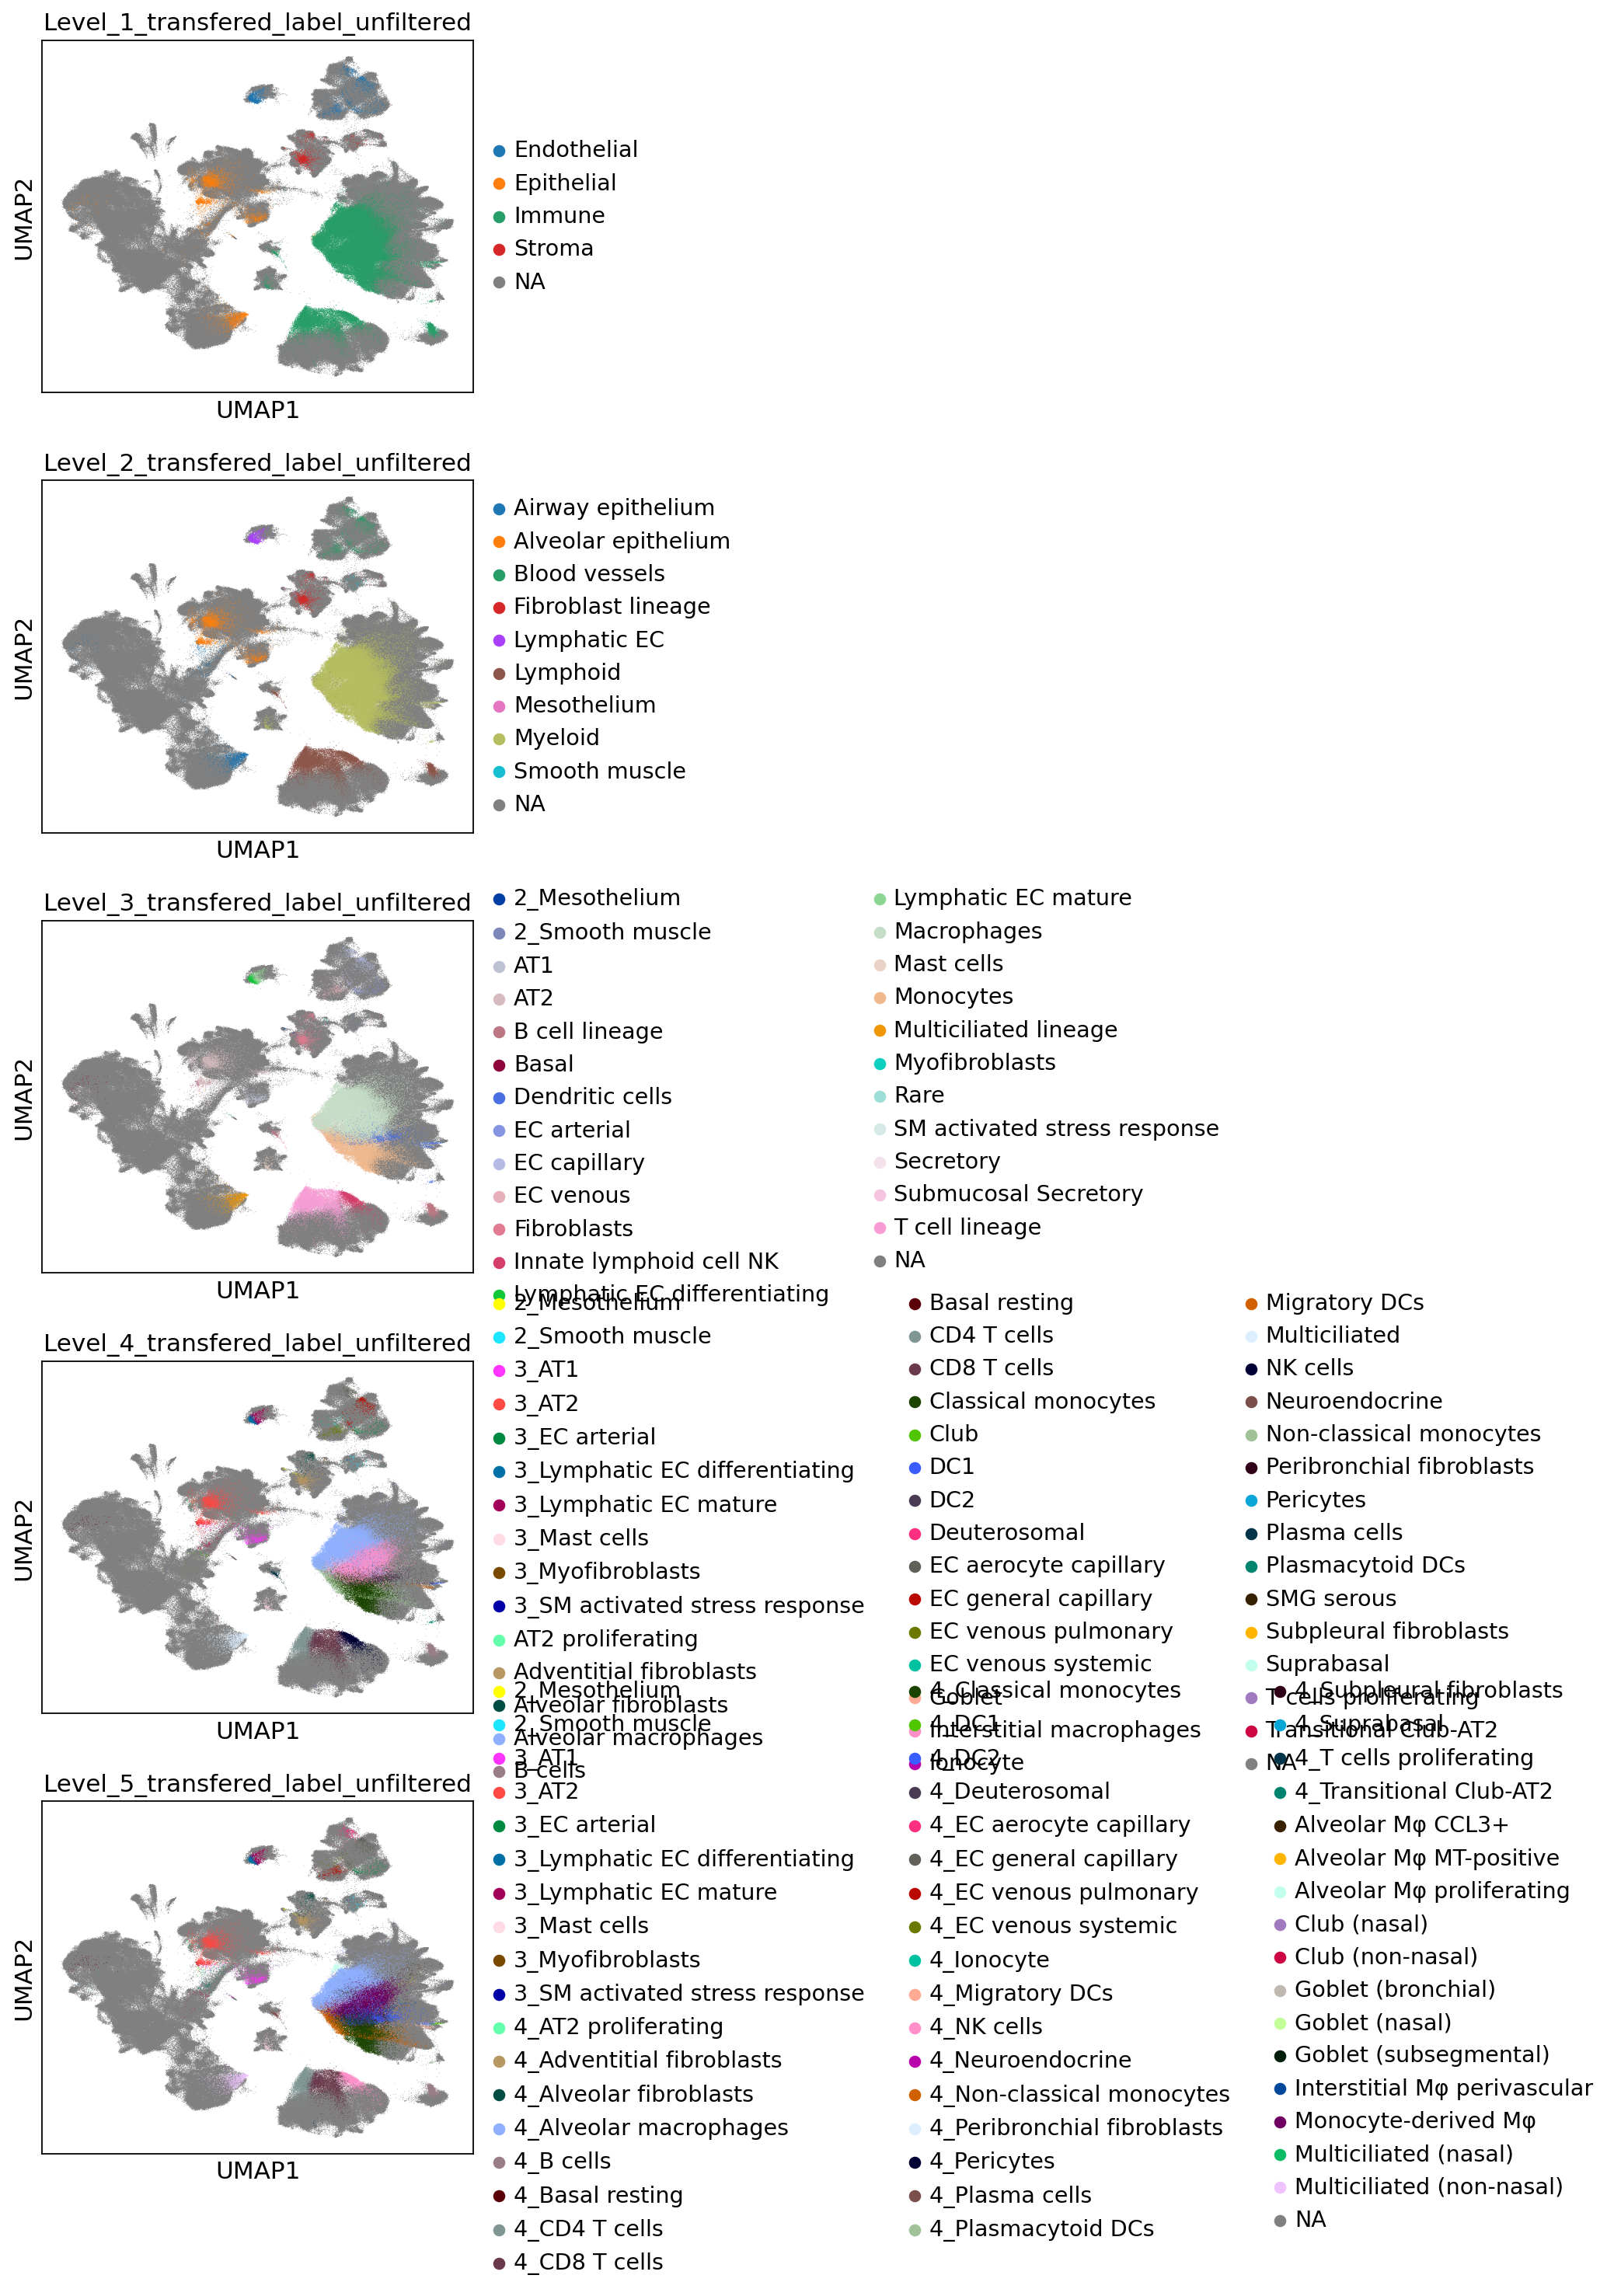

In [53]:
sc.pl.umap(
        combined_emb,
        color=[f"Level_{lev}_transfered_label_unfiltered" for lev in range(1,6)],
        na_color="grey",
        ncols=1,
        size=0.5
)

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


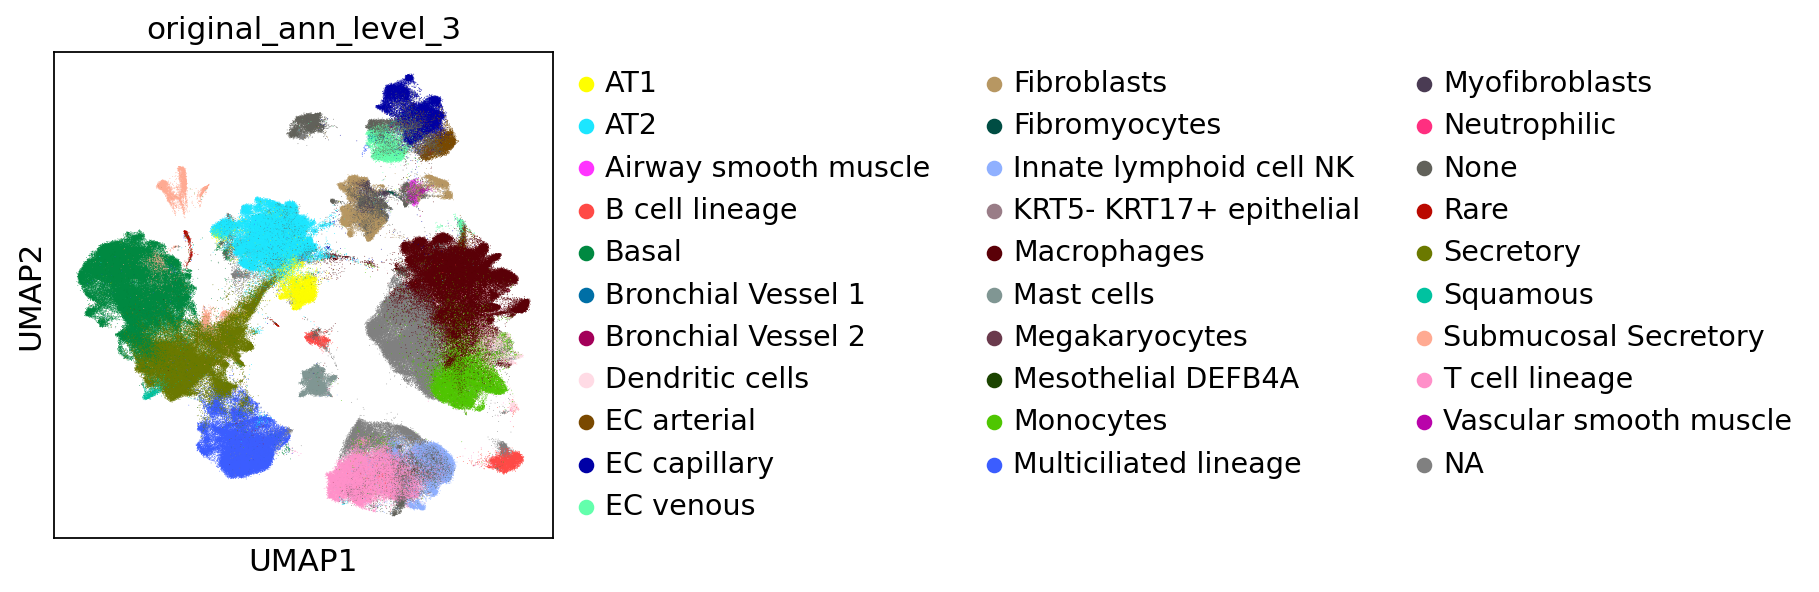

In [54]:
sc.pl.umap(
        combined_emb,
        color="original_ann_level_3",
        na_color="grey",
        ncols=1,
        size=0.5
)